In [1]:
import matplotlib.pyplot as plt

import finesse
from finesse.analysis import xaxis

finesse.plotting.init() # initialise matplotlib rcParams to appropriate values for a "display" mode
finesse.LOGGER.setLevel("WARN")

## Finesse 3 Introduction --- Fabry-Perot Cavity

This notebook is intended as an introduction to the Finesse 3 syntax and features by way of a simple example of a Fabry-Perot cavity configuration.

**Key Points**

- `.kat` files with largely the same syntax as Finesse 2 can be parsed into a Finesse 3 [Model](https://finesse.readthedocs.io/en/latest/api/finesse.model.html#module-finesse.model).
- This model object stores the [network](https://finesse.readthedocs.io/en/latest/api/generated/finesse.model.Model.network.html#finesse.model.Model.network) which is a directed graph
  where the `node_type` is the [full_name](https://finesse.readthedocs.io/en/latest/api/components/node/generated/finesse.components.node.Node.full_name.html#finesse.components.node.Node.full_name) property
  of a Node object. See [this documentation](https://finesse.readthedocs.io/en/latest/usage/advanced_usage/nodesystem/index.html) for in-depth details on the port and node system of Finesse 3.
- Parameter references can be set up in `.kat` files by using the `$` syntax:
  - track the parameter of another component using `$<comp_name>.param` -- e.g: `ad ampdet $EOM.f n1` tells Finesse to
    create an amplitude detector where the detection frequency is set up to track the frequency of the modulator named `EOM`.
  - more complicated referencing / tracking can be performed using `$$<eqn>$$` -- e.g. `ad ampdef $$EOM1.f + 2*EOM2.f$$ n1` tells Finesse
    to create an amplitude detector where the detection frequency is set to track a frequency equal to EOM1 modulation freq. plus two times EOM2 modulation freq.
- Simulations can be run over ranges of parameters with the `xaxis`, `x2axis` functions. Building of the Simulation object is performed internally within
  these functions using the model associated with the tunable parameters.

In the following cell we set up a Finesse model of a cavity using the familiar `.kat` style syntax. The amplitude detectors `Cp1` and `Cm1` are initialised such that the frequencies of the field that they detect track the positive and negative values of the modulator `eo1`, respectively. This means that if `eo1.f` is modified in any way later on, then `Cp1` and `Cm1` will still detect the upper and lower sidebands of the carrier circulating in the cavity. 

*Note: When we have different solvers (e.g. network reduction based solver) there may be an optional argument `solver="name_of_solver"` in xaxis, x2axis etc. which allows the user to choose which routine they want to use - defaulting to the current KLUMatrix solver acting on the whole coupling matrix.*

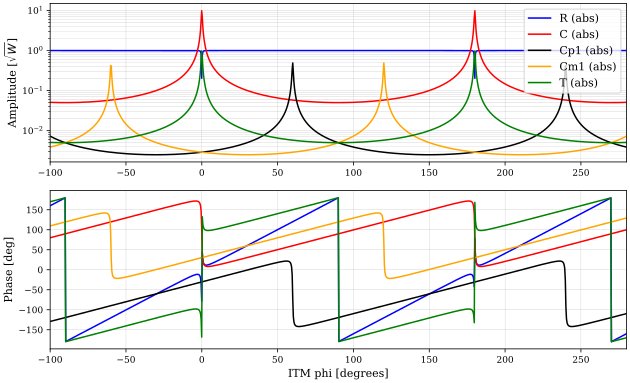

In [4]:
kat = finesse.Model()
kat.parse("""
l L0 P=1

s s0 L0.p1 EOM1.p1
mod EOM1 (
    f=100M
    midx=0.1
    order=1
    #mod_type=pm
)
s s1 EOM1.p2 ITM.p1 L=1

m ITM R=0.99 T=0.01
s sCAV ITM.p2 ETM.p1 L=1
m ETM R=0.99 T=0.01

ad R ITM.p1.o f=0
ad C ETM.p1.i f=0
ad Cp1 ETM.p1.i f=&EOM1.f
ad Cm1 ETM.p1.i f=(-&EOM1.f)
ad T ETM.p2.o f=0
""")

# run a simulation where we vary the tuning of m1 from -100 deg to 280 deg with 1000 steps
out = xaxis(kat.ITM.phi, -100, 280, 1000)
out.plot(logy=True, figsize_scale=1.5);

Upon running the simulation, we obtain an object `out` which acts as a wrapper around a `numpy` structured array whose named elements are the names of outputs in a model. So we can access, e.g., the output of the detector `Cp1` with `out['Cp1']`; whilst `out.x1` gives the data of the axis over which the first parameter was varied.